In [ ]:
!pip3 install torch torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/'My Drive'/Ms-Pacman-V0

ROMS


In [ ]:
import gym
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import datetime

In [ ]:
reward_number = 0.37

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.fc1 = nn.Linear(in_features=1792, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=9)
   
    def forward(self, x):
        x = x.cuda()
        x = F.relu(F.max_pool2d(self.convolution1(x), 3))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = x.reshape(x.size(0), - 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
model = CNN()

In [ ]:
model = model.cuda()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [ ]:
class DQNAgent:
    def __init__(self, action_size = 9):
        self.state_size = 4
        self.action_size = action_size
        self.memory_n = deque(maxlen=2000)
        self.memory_p = deque(maxlen=2000)
        self.gamma = 1.0    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.5
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = model

    def remember(self, state, action, reward, next_state, done):
        if reward == 0:
            self.memory_p.append((state, action, reward, next_state, done))
        else:
            self.memory_n.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.from_numpy(state).float()
        act_values = self.model(state_tensor).cpu().detach().numpy()
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        if len(agent.memory_n) > batch_size / 2:
            print("Negative batch ready:")
            minibatch_n = random.sample(self.memory_n, 5)
            minibatch_p = random.sample(self.memory_p, 59)
            minibatch = random.sample((minibatch_p+minibatch_n), batch_size)
        else:
            minibatch = random.sample(self.memory_p, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # reward = 0.001 if reward == 0 else 0.001
            ns_model = self.model(torch.from_numpy(next_state).float()).cpu().detach().numpy()
            if reward == 0:
                reward = 1.0001
                # print("Reward:", reward)
                target = reward * np.amax(ns_model[0])
                # print("target: ", target)
                target_f = ns_model
                # print("target_f: ", target_f)
                # print('Argmax: ', np.argmax(ns_model[0]))
                target_f[0][np.argmax(ns_model[0])] = target 
                # print("target_f[0][np.argmax(ns_model[0])]: ", target_f)            
            else:
                reward = reward_number
                # print("Reward:", reward)
                target = reward * np.amin(ns_model[0])
                # print("target: ", target)
                target_max = 0.0001 * np.amax(ns_model[0])
                # print("target_max: ", target_max)
                target_f = ns_model
                # print("target_f: ", target_f)
                target_f[0][action] = target
                target_f[0][random.choice([i for i in range(0,9) if i not in [action]])] = target_max
                # print("target_f[0][several actions]: ", target_f)
            self.train(next_state, target_f, epochs=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def train(self, input, target, epochs = 1):
        input = torch.from_numpy(input).float().cuda()
        target = torch.from_numpy(target).float().cuda()
        y_pred = 0
        for t in range(1):
            y_pred = model(input)
            loss = - criterion(y_pred, target)
            # print(t, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

    def load_all(self, name):
        loaded = torch.load(name)
        self.memory_n = loaded['memory_n']
        self.memory_p = loaded['memory_p']
        self.model.load_state_dict(loaded['state'])
        
    def save_all(self, name):
        torch.save({'state': self.model.state_dict(),
                    'memory_n': self.memory_n,
                    'memory_p': self.memory_p
                   }, name)
        
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [ ]:
!python -m atari_py.import_roms '/content/gdrive/MyDrive/Ms-Pacman-V0/ROMS'

copying frogger.bin from /content/gdrive/MyDrive/Ms-Pacman-V0/ROMS/Frogger (1982) (Parker Brothers, Ed English, David Lamkins) (PB5300) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/frogger.bin
copying gopher.bin from /content/gdrive/MyDrive/Ms-Pacman-V0/ROMS/Gopher (Gopher Attack) (1982) (U.S. Games Corporation - JWDA, Sylvia Day, Todd Marshall, Robin McDaniel, Henry Will IV) (VC2001) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/gopher.bin
copying galaxian.bin from /content/gdrive/MyDrive/Ms-Pacman-V0/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/galaxian.bin
copying frostbite.bin from /content/gdrive/MyDrive/Ms-Pacman-V0/ROMS/Frostbite (Iceman) (1983) (Activision, Steve Cartwright) (AX-031) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/frostbite.bin
copying hero.bin from /content/gdrive/MyDrive/Ms-Pacman-V0/R

In [ ]:
env = gym.make('MsPacman-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n

In [ ]:
agent = DQNAgent()

In [ ]:
done = False
batch_size = 32

In [ ]:
EPISODES = 20
score=[]
for e in range(EPISODES):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vw = cv2.VideoWriter('/content/gdrive/MyDrive/Ms-Pacman-V0/' + "Reward_number_" + str(reward_number) + "_" + str(e) + str(datetime.datetime.now()) +  '.avi', fourcc, 4, (160,210))
    state = env.reset()
    state = np.reshape(state, (1, 210,160,3)).transpose(0,3,1,2)/255
    for time in range(1000000000):
        print(time)
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        vw.write(next_state)        
        reward = reward if not done else 10
        reward = reward if reward ==0 else 10
        if reward != 0:
            print("ATTENTION NEGATIVE REWARD",reward)
        next_state = np.reshape(next_state, (1, 210,160,3)).transpose(0,3,1,2)/255
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            vw.release()
            agent.save('/content/gdrive/MyDrive/Ms-Pacman-V0/' + "Reward_number_" + str(reward_number) + "_""Frames:_" + str(time) + "_Episode_" +str(e) + "_Date_" + str(datetime.datetime.now()) + '.pt')
            print("episode: {}/{}, score: {}, e: {:.2}".format(e+1, EPISODES , time, agent.epsilon))
            score.append(time)
            break
        if (len(agent.memory_p) > batch_size) & (len(agent.memory_n) > batch_size/2) :
            agent.replay(batch_size)

Streaming output truncated to the last 5000 lines.
612
Negative batch ready:
613
Negative batch ready:
614
Negative batch ready:
615
Negative batch ready:
616
Negative batch ready:
617
Negative batch ready:
618
Negative batch ready:
619
Negative batch ready:
620
Negative batch ready:
621
Negative batch ready:
622
Negative batch ready:
623
Negative batch ready:
624
Negative batch ready:
625
Negative batch ready:
626
Negative batch ready:
627
Negative batch ready:
628
Negative batch ready:
629
Negative batch ready:
630
Negative batch ready:
631
Negative batch ready:
632
Negative batch ready:
633
Negative batch ready:
634
Negative batch ready:
635
Negative batch ready:
636
Negative batch ready:
637
Negative batch ready:
638
Negative batch ready:
639
Negative batch ready:
640
Negative batch ready:
641
Negative batch ready:
642
Negative batch ready:
643
Negative batch ready:
644
Negative batch ready:
645
Negative batch ready:
646
Negative batch ready:
647
Negative batch ready:
648
Negative 

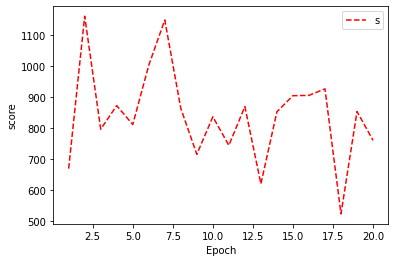

In [ ]:
# Create count of the number of epochs
epoch_count = range(1, len(score) + 1)

# Visualize loss history
plt.plot(epoch_count, score, 'r--')
plt.legend('score vs episode')
plt.xlabel('Epoch')
plt.ylabel('score')
plt.show()

In [ ]:
%history

!pip3 install torch torchvision
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/'Shared with me'/Ms-Pacman-V0
!ls gdrive/'My Drive'/Ms-Pacman-V0
import gym
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import datetime
reward_number = 0.37
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.fc1 = nn.Linear(in_features=1792, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=32)
        

In [ ]:
!ls '/content/gdrive/MyDrive/Ms-Pacman-V0/'

'Reward_number_0.37_02022-04-06 23:22:40.990813.avi'
'Reward_number_0.37_102022-04-06 23:57:00.692091.avi'
'Reward_number_0.37_112022-04-07 00:00:05.953388.avi'
'Reward_number_0.37_12022-04-06 23:23:39.808887.avi'
'Reward_number_0.37_122022-04-07 00:03:38.344841.avi'
'Reward_number_0.37_132022-04-07 00:06:09.549524.avi'
'Reward_number_0.37_142022-04-07 00:09:36.379320.avi'
'Reward_number_0.37_152022-04-07 00:13:14.332847.avi'
'Reward_number_0.37_162022-04-07 00:16:54.287364.avi'
'Reward_number_0.37_172022-04-07 00:20:39.886983.avi'
'Reward_number_0.37_182022-04-07 00:22:46.871237.avi'
'Reward_number_0.37_192022-04-07 00:26:16.056050.avi'
'Reward_number_0.37_22022-04-06 23:28:23.238315.avi'
'Reward_number_0.37_32022-04-06 23:31:37.836725.avi'
'Reward_number_0.37_42022-04-06 23:35:10.494048.avi'
'Reward_number_0.37_52022-04-06 23:38:28.279316.avi'
'Reward_number_0.37_62022-04-06 23:42:32.209440.avi'
'Reward_number_0.37_72022-04-06 23:47:10.328994.avi'
'Reward_number_0.37_82022-04-06 23:5